/var/folders/1l/7dk3svz97wdcq01rlzd7rzpc0000gn/T/ipykernel_34709/643191997.py:95: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  contour_points = contour_2sigma.collections[0].get_paths()[0].vertices
/var/folders/1l/7dk3svz97wdcq01rlzd7rzpc0000gn/T/ipykernel_34709/643191997.py:96: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  cc_points = cc_2sigma.collections[0].get_paths()[0].vertices
/var/folders/1l/7dk3svz97wdcq01rlzd7rzpc0000gn/T/ipykernel_34709/643191997.py:130: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  contour_paths = contour_2sigma.collections[0].get_paths()


Area enclosed by BDT 2σ contour: -577.5713684647358
Area enclosed by Cut and Count 2σ contour: -365.77418875422234
Difference in areas: -211.79717971051343
Percentage Improvement: 57.90%
(14.00, 4.39594311e-10)
(16.00, 2.66269921e-10)
(17.68, 1.77827941e-10)
(43.65, 1.77827941e-10)
(44.00, 2.07222194e-10)
(46.00, 2.19072032e-10)
(50.43, 5.62341325e-10)
(54.00, 5.91456213e-10)
(56.00, 5.96659288e-10)
(63.72, 1.77827941e-09)
(64.00, 2.29790505e-09)
(66.00, 2.84261486e-09)
(74.00, 4.70405768e-09)
(76.00, 4.87197784e-09)


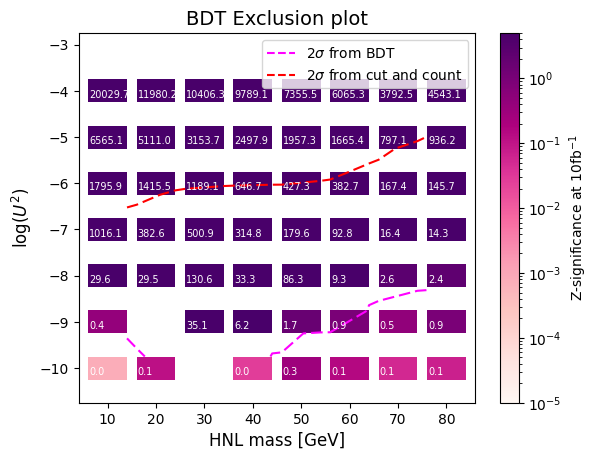

In [2]:
## RUN 12 Prompt Decay ###
## RUN 11 -- 15 GeeV Filter -- ##

## 22 March 2024 ##

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
from scipy.interpolate import griddata
from matplotlib.lines import Line2D
import json
from sklearn.metrics import auc

with open('test_xgboost_results12_10fb.json', 'r') as file:
    
    data = json.load(file)
    
def make_hist_2D():

    #10 fb-1 data

    #data_points = [('10', -4.0, 27.778574889916563), ('10', -5.0, 7.9098872059916365), ('10', -6.0, 2.321909727607213), ('10', -7.0, 0.0009543498604278071), ('10', -8.0, 0.05579593603714217), ('10', -9.0, 6.016719461905977e-08), ('10', -10.0, 8.675845754470089e-06), ('20', -4.0, 17.845892334515295), ('20', -5.0, 5.108197588635191), ('20', -6.0, 1.0769853307552089), ('20', -7.0, 0.0018679408941489326), ('20', -8.0, 0.01952953104055794), ('20', -9.0, 6.401283052342732e-07), ('20', -10.0, 1.7086127338175105e-05), ('30', -4.0, 16.2862566546243), ('30', -5.0, 3.8699231500332623), ('30', -6.0, 0.7338425118418546), ('30', -7.0, 0.001109623620388535), ('30', -8.0, 0.010895638995044797), ('40', -4.0, 15.281028458541495), ('40', -5.0, 3.69548224976052), ('40', -6.0, 0.7348459050973114), ('40', -7.0, 0.0011912950804715996), ('40', -8.0, 0.011769179453659795), ('40', -10.0, 0), ('50', -4.0, 14.290300427271251), ('50', -5.0, 3.668737074259249), ('50', -6.0, 0.8216503610726512), ('50', -7.0, 0.0018133807230021758), ('50', -8.0, 0.01768896886838045), ('50', -10.0, 0), ('60', -4.0, 10.520843819835253), ('60', -5.0, 2.6176704965000233), ('60', -6.0, 0.5547729100572643), ('60', -7.0, 0.0010488922154181857), ('60', -8.0, 0.01024677129570917), ('60', -9.0, 1.0833692200417029e-05), ('60', -10.0, 0.00010498732308894972), ('70', -4.0, 5.771373976106098), ('70', -5.0, 1.31711669256286), ('70', -6.0, 0.24014289367746705), ('70', -7.0, 0.00033557696678828986), ('70', -8.0, 0.003338965933987431), ('70', -9.0, 3.3597480736752614e-06), ('70', -10.0, 3.3733149035896306e-05), ('80', -4.0, 0.4087316635166447), ('80', -5.0, 0.055734614012993344), ('80', -6.0, 0.005953706853334397), ('80', -7.0, 9.877514849343938e-06), ('80', -8.0, 6.052385900507629e-05), ('80', -9.0, 1.0858669922899504e-07), ('80', -10.0, 6.372843482819998e-07)]

    data_points = []

    for key, value in data.items():
        parts = key.split('_')
        mass = float(parts[1].replace('GeV', ''))  # Just take the number
        
        # Replace '1e-' with '-' and 'p' with '.'
        angle = float(parts[2].replace('1e-', '-').replace('p', '.'))
        highest_significance_entry = max(value['significance_list'], key=lambda x: x[0])
        highest_significance = highest_significance_entry[0]

        data_points.append((mass, angle, highest_significance))

    masses = [float(data[0]) for data in data_points]
    angles = [float(data[1] * 2) for data in data_points]
    #angles = [angle * 2 for angle in angles]  # Angle squared is 10^(2 * exponent)
    significances = [data[2] * 122 for data in data_points]

    x_range = (0, 90)
    y_range = (-11, -3)
    
    x_bins = [4, 6, 14, 16, 24, 26, 34, 36, 44, 46, 54, 56, 64, 66, 74, 76, 84, 86]
    y_bins = np.arange(-10.75, -2.25, 0.5)

    n_bins = [x_bins, y_bins]


    norm = LogNorm(vmin=1e-5, vmax=5)

    cmap = plt.cm.RdPu

    plt.hist2d(masses, angles, bins=n_bins, range=[x_range, y_range], weights=significances, cmap=cmap, norm=norm)

    hist, edges = np.histogramdd((masses, angles), bins=n_bins, range=[x_range, y_range], weights=significances)
    x_edges, y_edges = edges
    
    plt.colorbar(label = 'Z-significance at $10 \mathrm{fb}^{-1}$')
    #plt.colorbar.set_label("Z significance at  $150 \, \mathrm{ab}^{-1}$", fontsize = 12)
    ###delimiting line
    threshold = 2.0
    x_grid, y_grid = np.meshgrid(x_bins, y_bins)

    ###former data from cut and count (cc)###

    data_points_cc = [["10", -4.0, 52.876748861276596], ["10", -5.0, 15.128775602656333], ["10", -6.0, 4.4804573585508045], ["10", -7.0, 0.001475996382017464], ["10", -8.0, 0.08968425151707608], ["10", -9.0, 5.99037429924615e-08], ["10", -10.0, 1.4097477838218989e-05], ["20", -4.0, 36.2857862213626], ["20", -5.0, 10.884431421876464], ["20", -6.0, 2.4678689415467248], ["20", -7.0, 0.004537376980651871], ["20", -8.0, 0.058997010448686465], ["20", -9.0, 1.163004130746887e-06], ["20", -10.0, 3.352827837383747e-05], ["30", -4.0, 32.92212247543547], ["30", -5.0, 8.315052417103097], ["30", -6.0, 1.7459934119249754], ["30", -7.0, 0.0033373434392724114], ["30", -8.0, 0.029476881359299892], ["40", -4.0, 29.429788400754102], ["40", -5.0, 7.506664142646672], ["40", -6.0, 1.5869986460516172], ["40", -7.0, 0.0029276961561613734], ["40", -8.0, 0.02821520628356613], ["40", -10.0, 0], ["50", -4.0, 25.62219372240296], ["50", -5.0, 6.763465781950523], ["50", -6.0, 1.5570028443548596], ["50", -7.0, 0.003920231273620948], ["50", -8.0, 0.03817629371414823], ["50", -10.0, 0], ["60", -4.0, 18.866071450665995], ["60", -5.0, 4.839367338887292], ["60", -6.0, 1.0775817568201167], ["60", -7.0, 0.00230040705768753], ["60", -8.0, 0.022811124653626037], ["60", -9.0, 2.3613377004847655e-05], ["60", -10.0, 0.0002345337086266546], ["70", -4.0, 11.254577646746137], ["70", -5.0, 2.7412790459120084], ["70", -6.0, 0.5486607337910216], ["70", -7.0, 0.0008222118582734013], ["70", -8.0, 0.008246616737636249], ["70", -9.0, 8.055020468869638e-06], ["70", -10.0, 8.326387828664493e-05], ["80", -4.0, 0.6762462099536374], ["80", -5.0, 0.09792341746750198], ["80", -6.0, 0.010659487433272599], ["80", -7.0, 9.878873485179866e-06], ["80", -8.0, 0.00010780352635664964], ["80", -9.0, 1.508599479535031e-07], ["80", -10.0, 1.2065998272242434e-06]]

    masses_cc = [float(data[0]) for data in data_points_cc]
    angles_cc = [float(data[1]) for data in data_points_cc]
    significances_cc = [data[2] for data in data_points_cc]

    # CMS limit data 2022
    CMS_schan_data = [
        [(10.04700595976151, 0.000023082141010113102), (12.524479150951855, 0.000011749332926243381), (15.179683940866253, 0.000007721730911100832), (20.01822940694026, 0.000004804387683161414), (25.78726571567961, 0.000004548413852965408), (29.962525137893632, 0.000004466156629057755)],
        [(30.103366862992136, 0.000004151737193313069), (39.69885711271743, 0.0000049829908817852205)],
        [(40.07295085888878, 0.000004466156629057755), (45.6959594536167, 0.000006203008521807331), (49.48812713122432, 0.000007721730911100832), (60.261610378466074, 0.00001516971923861933), (61.691315697137924, 0.000022254817759219363), (64.35080313023565, 0.000038477314721614524), (66.4983073091065, 0.00006298068757509268), (69.36502218805408, 0.00011501809818547428), (73.03714496129122, 0.00022187227592620327), (74.76994954377685, 0.00032549890930020297)],
        [(85.26161686302474, 0.0011678073441030935), (100, 0.0008881388040948054), (124.65882075827045, 0.002379502302954701)],
        [(125.24479150951849, 0.0019825579550753307), (200.18229406940262, 0.004039622839900939), (248.37736550889213, 0.007513211723105277)],
        [(250.7178968461945, 0.01559073459853915), (349.77453457549154, 0.03235247644819765), (398.85465400719255, 0.0474628736424529)],
        [(402.61317610448566, 0.035443585468687214), (497.2075082248459, 0.05593559254401127), (599.7967018215691, 0.07768848834485403), (713.4449837997322, 0.12486286316811376), (949.7225312519636, 0.299835071527624), (1119.1281942186895, 0.5279455915282002), (1212.0012144147804, 0.7069774281986929), (1276.163484104214, 0.912787914100269), (1408.238362859069, 1.414472315683253), (1496.7620027126732, 1.929020557864024)]
    ]

    # Perform the interpolation
    z_interp = griddata((masses, angles), significances, (x_grid, y_grid), method='linear')
    z_cut_count = griddata((masses_cc, angles_cc), significances_cc, (x_grid, y_grid), method='linear')
    # Contour lines
    contour_2sigma = plt.contour(x_grid, y_grid, z_interp, levels=[threshold], colors='magenta', linestyles='dashed')
    
    cc_2sigma = plt.contour(x_grid, y_grid, z_cut_count, levels=[threshold], colors='red', linestyles='dashed')
    #contour_5sigma = plt.contour(x_grid, y_grid, z_interp, levels=[5.0], colors='blue')
    
    # Identify the coordinates of the 2σ contours
    contour_points = contour_2sigma.collections[0].get_paths()[0].vertices
    cc_points = cc_2sigma.collections[0].get_paths()[0].vertices

    # Calculate the area enclosed by the contours
    area_contour = auc(contour_points[:, 0], contour_points[:, 1])
    area_cc = auc(cc_points[:, 0], cc_points[:, 1])

    # Find the difference in areas
    area_difference = area_contour - area_cc

    print(f"Area enclosed by BDT 2σ contour: {area_contour}")
    print(f"Area enclosed by Cut and Count 2σ contour: {area_cc}")
    print(f"Difference in areas: {area_difference}")
    # Find the difference in areas
    percentage_improvement = (area_difference / area_cc) * 100

    print(f"Percentage Improvement: {percentage_improvement:.2f}%")
    
    # Create legend entries
    legend_elements = [Line2D([0], [0], color='magenta', linestyle='dashed', label='2$\sigma$ from BDT'),
                       Line2D([0], [0], color='red', linestyle='dashed', label='2$\sigma$ from cut and count')]
                       #Line2D([0], [0], color='blue', label='5$\sigma$')]

    plt.legend(handles=legend_elements, loc='upper right')

    plt.xlabel("HNL mass [GeV]", fontsize=12)
    plt.ylabel("log($U^2$)", fontsize=12)
    plt.title("BDT Exclusion plot", fontsize=14)

    
    for i in range(len(x_edges) -1):
        for j in range(len(y_edges) -1):
            if hist[i, j] > 0:
                plt.text(x_edges[i] +0.2, y_edges[j]+0.1, f'{hist[i, j]:.1f}', color='white', fontsize = 7)

    contour_paths = contour_2sigma.collections[0].get_paths()
    for path in contour_paths:
        vertices = path.vertices
        converted_vertices = np.copy(vertices)
        converted_vertices[:, 1] = 10**((vertices[:, 1]))  # Convert log(U^2) to U^2
        for vertex in converted_vertices:
            print(f"({vertex[0]:.2f}, {vertex[1]:.8e})")  # Print as (x, U^2) in decimal form



    plt.savefig('exclusionplot_10fb_run12_LLP.pdf', format='pdf')
    plt.show()

make_hist_2D()



TypeError: Input z must be 2D, not 1D

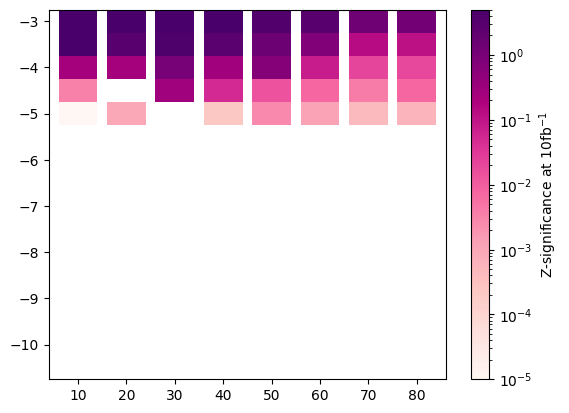

In [146]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
from scipy.interpolate import griddata
from matplotlib.lines import Line2D
import json
from sklearn.metrics import auc

# Load BDT results
with open('test_xgboost_results12_10fb.json', 'r') as file:
    data = json.load(file)

def make_hist_2D():
    data_points = []

    # Extract BDT data points
    for key, value in data.items():
        parts = key.split('_')
        mass = float(parts[1].replace('GeV', ''))
        angle = float(parts[2].replace('1e-', '-').replace('p', '.'))
        highest_significance = max(value['significance_list'], key=lambda x: x[0])[0]
        data_points.append((mass, angle, highest_significance))

    masses, angles, significances = zip(*data_points)
    x_range = (0, 90)
    y_range = (-11, -3)
    x_bins = [4, 6, 14, 16, 24, 26, 34, 36, 44, 46, 54, 56, 64, 66, 74, 76, 84, 86]
    y_bins = np.arange(-10.75, -2.25, 0.5)

    # Histogram plot settings
    norm = LogNorm(vmin=1e-5, vmax=5)
    cmap = plt.cm.RdPu
    plt.hist2d(masses, angles, bins=[x_bins, y_bins], range=[x_range, y_range], weights=significances, cmap=cmap, norm=norm)
    plt.colorbar(label='Z-significance at $10 \mathrm{fb}^{-1}$')

    # CMS data
    CMS_masses = np.array([10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0])
    CMS_logU2 = np.log10([2.3e-5, 4.8e-6, 4.5e-6, 4.5e-6, 3.7e-6, 6.2e-6, 7.7e-6, 7.7e-6])

    # Plot CMS data as a contour
    plt.contour(CMS_masses, CMS_logU2, levels=[1], colors='green', linestyles='dashed', label='CMS Limit')

    # BDT and Cut and Count contours
    threshold = 2.0
    z_interp = griddata((masses, angles), significances, (np.meshgrid(x_bins, y_bins)), method='linear')
    contour_2sigma = plt.contour(x_bins, y_bins, z_interp, levels=[threshold], colors='magenta', linestyles='dashed', label='2σ from BDT')

    # Legend and labels
    plt.legend(handles=[Line2D([0], [0], color='magenta', linestyle='dashed', label='2σ from BDT'),
                        Line2D([0], [0], color='green', linestyle='dashed', label='CMS Limit')])
    plt.xlabel("HNL mass [GeV]", fontsize=12)
    plt.ylabel("log($U^2$)", fontsize=12)
    plt.title("BDT Exclusion plot", fontsize=14)
    plt.show()

make_hist_2D()


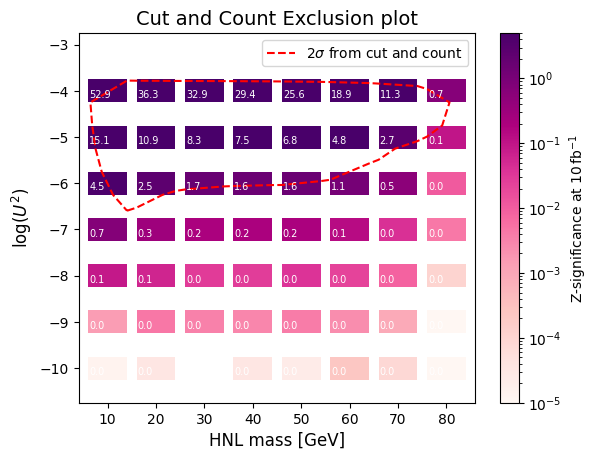

In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
from scipy.interpolate import griddata
from matplotlib.lines import Line2D
import json
from sklearn.metrics import auc

def make_hist_2D():

    x_range = (0, 90)
    y_range = (-11, -3)
    
    x_bins = [4, 6, 14, 16, 24, 26, 34, 36, 44, 46, 54, 56, 64, 66, 74, 76, 84, 86]
    y_bins = np.arange(-10.75, -2.25, 0.5)

    n_bins = [x_bins, y_bins]

    norm = LogNorm(vmin=1e-5, vmax=5)

    cmap = plt.cm.RdPu

    data_points_cc = [["10", -4.0, 52.876748861276596], ["10", -5.0, 15.128775602656333], ["10", -6.0, 4.4804573585508045], ["10", -7.0, 0.7015996382017464], ["10", -8.0, 0.08968425151707608], ["10", -9.0, 0.001475996382017464], ["10", -10.0, 1.4097477838218989e-05], ["20", -4.0, 36.2857862213626], ["20", -5.0, 10.884431421876464], ["20", -6.0, 2.4678689415467248], ["20", -7.0, 0.304537376980651871], ["20", -8.0, 0.058997010448686465], ["20", -9.0, 0.004537376980651871], ["20", -10.0, 3.352827837383747e-05], ["30", -4.0, 32.92212247543547], ["30", -5.0, 8.315052417103097], ["30", -6.0, 1.7459934119249754], ["30", -7.0, 0.2033373434392724114], ["30", -8.0, 0.029476881359299892],["30", -9.0, 0.0033373434392724114], ["40", -4.0, 29.429788400754102], ["40", -5.0, 7.506664142646672], ["40", -6.0, 1.5869986460516172], ["40", -7.0, 0.2029276961561613734], ["40", -8.0, 0.02821520628356613],["40", -9.0, 0.0029276961561613734], ["40", -10.0, 3.352827837383747e-05], ["50", -4.0, 25.62219372240296], ["50", -5.0, 6.763465781950523], ["50", -6.0, 1.5570028443548596], ["50", -7.0, 0.203920231273620948], ["50", -8.0, 0.03817629371414823],["50", -9.0, 0.003920231273620948], ["50", -10.0, 2.352827837383747e-05], ["60", -4.0, 18.866071450665995], ["60", -5.0, 4.839367338887292], ["60", -6.0, 1.0775817568201167], ["60", -7.0, 0.13230040705768753], ["60", -8.0, 0.022811124653626037], ["60", -9.0, 0.00230040705768753], ["60", -10.0, 0.0002345337086266546], ["70", -4.0, 11.254577646746137], ["70", -5.0, 2.7412790459120084], ["70", -6.0, 0.5486607337910216], ["70", -7.0, 0.0408222118582734013], ["70", -8.0, 0.008246616737636249], ["70", -9.0, 0.0008222118582734013], ["70", -10.0, 8.326387828664493e-05], ["80", -4.0, 0.6762462099536374], ["80", -5.0, 0.09792341746750198], ["80", -6.0, 0.010659487433272599], ["80", -7.0, 0.00423984398430349], ["80", -8.0, 0.00010780352635664964], ["80", -9.0, 9.878873485179866e-06], ["80", -10.0, 1.2065998272242434e-06]]

    masses_cc = [float(data[0]) for data in data_points_cc]
    angles_cc = [float(data[1]) for data in data_points_cc]
    significances_cc = [data[2] for data in data_points_cc]


    plt.hist2d(masses_cc, angles_cc, bins=n_bins, range=[x_range, y_range], weights=significances_cc, cmap=cmap, norm=norm)

    hist, edges = np.histogramdd((masses_cc, angles_cc), bins=n_bins, range=[x_range, y_range], weights=significances_cc)
    x_edges, y_edges = edges
    
    plt.colorbar(label = 'Z-significance at $10 \, \mathrm{fb}^{-1}$')
    #plt.colorbar.set_label("Z significance at  $150 \, \mathrm{ab}^{-1}$", fontsize = 12)
    ###delimiting line
    threshold = 2.0
    x_grid, y_grid = np.meshgrid(x_bins, y_bins)

    ###former data from cut and count (cc)###

    # Perform the interpolation
    z_cut_count = griddata((masses_cc, angles_cc), significances_cc, (x_grid, y_grid), method='linear',fill_value=0)
    # Contour lines
    cc_2sigma = plt.contour(x_grid, y_grid, z_cut_count, levels=[threshold], colors='red', linestyles='dashed')
    #contour_5sigma = plt.contour(x_grid, y_grid, z_interp, levels=[5.0], colors='blue')
    # Create legend entries
    legend_elements = [
                       Line2D([0], [0], color='red', linestyle='dashed', label='2$\sigma$ from cut and count')]
                       #Line2D([0], [0], color='blue', label='5$\sigma$')]

    plt.legend(handles=legend_elements, loc='upper right')

    plt.xlabel("HNL mass [GeV]", fontsize=12)
    plt.ylabel("log($U^2$)", fontsize=12)
    plt.title("Cut and Count Exclusion plot", fontsize=14)

    
    for i in range(len(x_edges) -1):
        for j in range(len(y_edges) -1):
            if hist[i, j] > 0:
                plt.text(x_edges[i] +0.2, y_edges[j]+0.1, f'{hist[i, j]:.1f}', color='white', fontsize = 7)

    
    plt.savefig('cut_and_count_10fb.pdf', format='pdf')
    plt.show()

make_hist_2D()

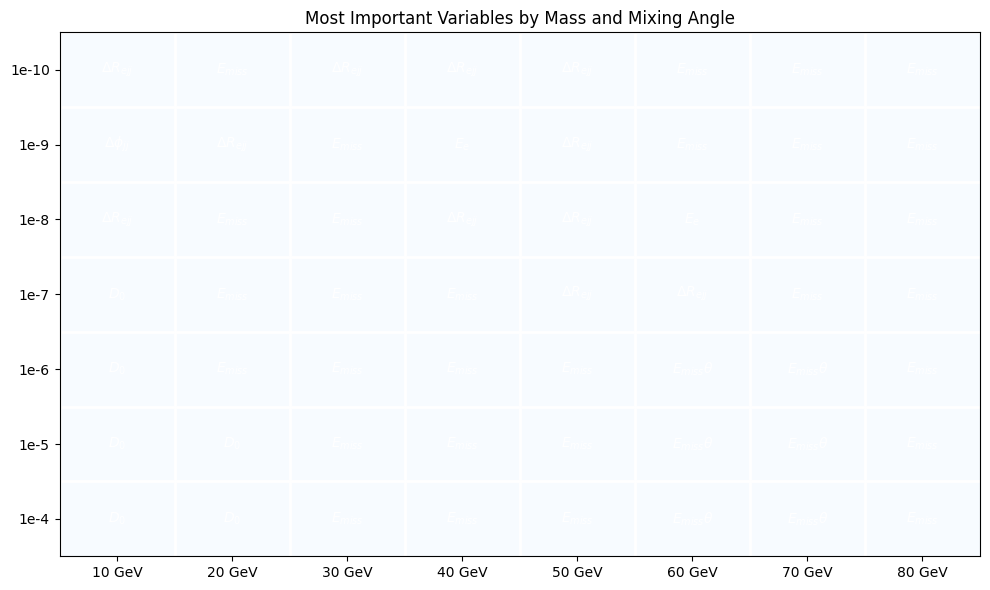

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Define mass points and mixing angles
masses = np.arange(10, 90, 10)  # Mass points from 10 to 80 GeV
mixing_angles = ['1e-10', '1e-9', '1e-8', '1e-7', '1e-6', '1e-5', '1e-4']  # Mixing angles

# Manually define the most important variable for each mass and mixing angle
important_features = [
    [r'$\Delta R_{ejj}$', r'$\Delta \phi_{jj}$', r'$\Delta R_{ejj}$', r'$D_{0}$', r'$D_{0}$', r'$D_{0}$', r'$D_{0}$'],   
    [r'$E_{miss}$', r'$\Delta R_{ejj}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$D_{0}$', r'$D_{0}$'],
    [r'$\Delta R_{ejj}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$'],
    [r'$\Delta R_{ejj}$', r'$E_{e}$', r'$\Delta R_{ejj}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$'],
    [r'$\Delta R_{ejj}$', r'$\Delta R_{ejj}$', r'$\Delta R_{ejj}$', r'$\Delta R_{ejj}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$'],
    [r'$E_{miss}$', r'$E_{miss}$', r'$E_{e}$', r'$\Delta R_{ejj}$', r'$E_{miss} \theta$', r'$E_{miss} \theta$', r'$E_{miss} \theta$'],
    [r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss} \theta$', r'$E_{miss} \theta$', r'$E_{miss} \theta$'],
    [r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$']
]

# Create a heatmap plot
fig, ax = plt.subplots(figsize=(10, 6))
# Create a single color array, and increase the line width for gridlines
colors = np.full((len(mixing_angles), len(masses)), 0.5)  # Uniform color
im = ax.imshow(colors, cmap='Blues', aspect='auto')

# Setting gridlines manually
ax.set_xticks(np.arange(len(masses)) - .5, minor=True)
ax.set_yticks(np.arange(len(mixing_angles)) - .5, minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=2)
ax.tick_params(which="minor", size=0)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(masses)))
ax.set_yticks(np.arange(len(mixing_angles)))
ax.set_xticklabels([f'{mass} GeV' for mass in masses])
ax.set_yticklabels(mixing_angles)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=0, ha="center")

# Loop over data dimensions and create text annotations.
for i in range(len(mixing_angles)):
    for j in range(len(masses)):
        text = ax.text(j, i, important_features[j][i],
                       ha="center", va="center", color="white")

ax.set_title("Most Important Variables by Mass and Mixing Angle")
fig.tight_layout()
plt.show()


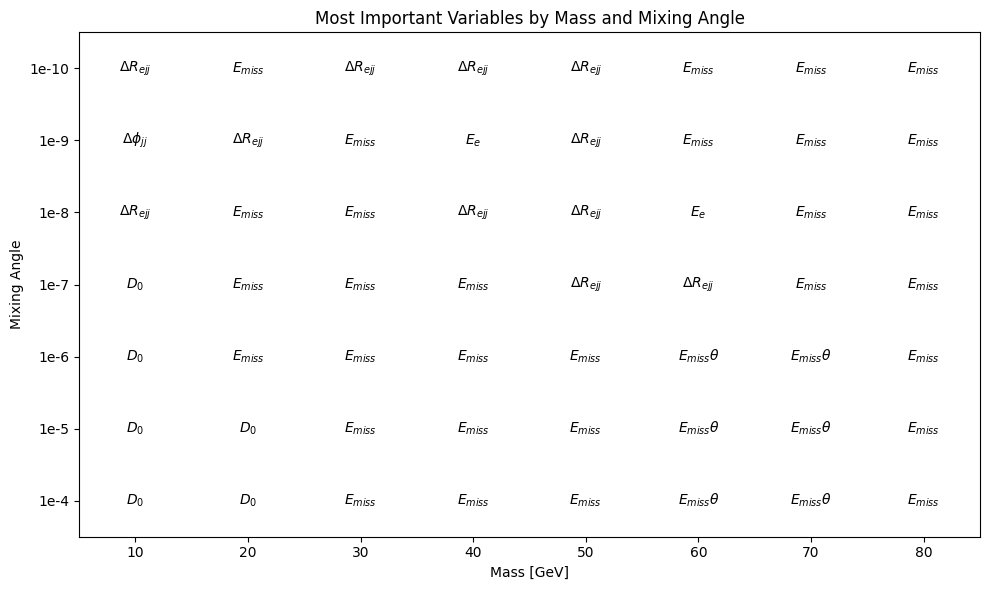

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Define mass points and mixing angles
masses = np.arange(10, 90, 10)  # Mass points from 10 to 80 GeV
mixing_angles = ['1e-4', '1e-5', '1e-6', '1e-7', '1e-8', '1e-9', '1e-10']  # Mixing angles from 10^-4 to 10^-10

important_features = [
    [r'$\Delta R_{ejj}$', r'$\Delta \phi_{jj}$', r'$\Delta R_{ejj}$', r'$D_{0}$', r'$D_{0}$', r'$D_{0}$', r'$D_{0}$'],   
    [r'$E_{miss}$', r'$\Delta R_{ejj}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$D_{0}$', r'$D_{0}$'],
    [r'$\Delta R_{ejj}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$'],
    [r'$\Delta R_{ejj}$', r'$E_{e}$', r'$\Delta R_{ejj}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$'],
    [r'$\Delta R_{ejj}$', r'$\Delta R_{ejj}$', r'$\Delta R_{ejj}$', r'$\Delta R_{ejj}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$'],
    [r'$E_{miss}$', r'$E_{miss}$', r'$E_{e}$', r'$\Delta R_{ejj}$', r'$E_{miss} \theta$', r'$E_{miss} \theta$', r'$E_{miss} \theta$'],
    [r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss} \theta$', r'$E_{miss} \theta$', r'$E_{miss} \theta$'],
    [r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$']
]

# Create a heatmap plot
fig, ax = plt.subplots(figsize=(10, 6))
# Create a single color array, and increase the line width for gridlines
colors = np.full((len(mixing_angles), len(masses)), 0.5)  # Uniform color
im = ax.imshow(colors, cmap='Greys', aspect='auto')

# Setting gridlines manually
ax.set_xticks(np.arange(len(masses)) - .5, minor=True)
ax.set_yticks(np.arange(len(mixing_angles)) - .5, minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=2)
ax.tick_params(which="minor", size=0)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(masses)))
ax.set_yticks(np.arange(len(mixing_angles)))
ax.set_xticklabels([f'{mass}' for mass in masses])
ax.set_yticklabels(mixing_angles[::-1])  # Reverse the mixing angles for display

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=0, ha="center")

# Loop over data dimensions and create text annotations.
for i in range(len(mixing_angles)):
    for j in range(len(masses)):
        text = ax.text(j, i, important_features[j][i],
                       ha="center", va="center", color="black")

ax.set_title("Most Important Variables by Mass and Mixing Angle")
ax.set_xlabel('Mass [GeV]')
ax.set_ylabel('Mixing Angle')
fig.tight_layout()
plt.show()


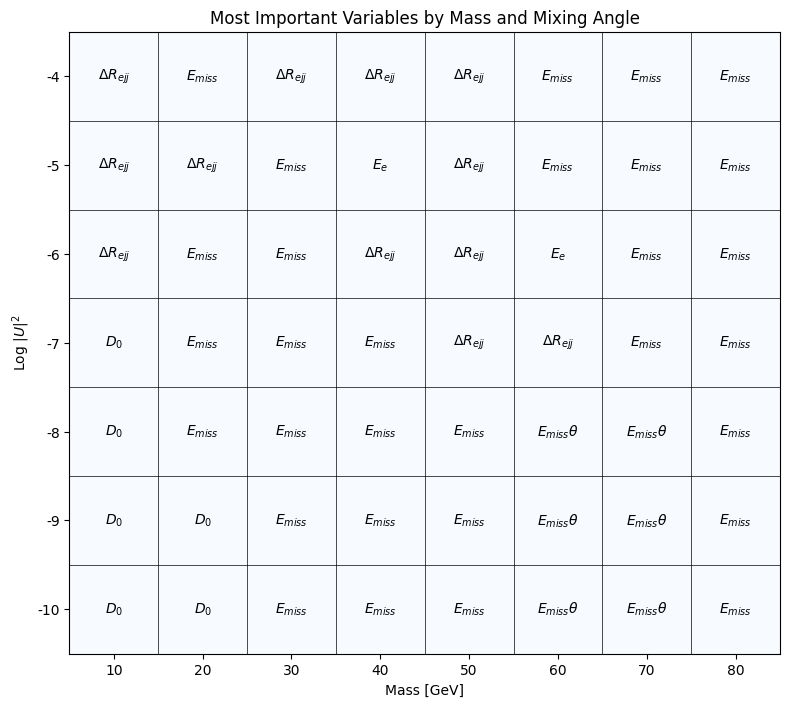

In [71]:
import matplotlib.pyplot as plt
import numpy as np

# Define mass points and mixing angles
masses = np.arange(10, 90, 10)  # Mass points from 10 to 80 GeV
mixing_angles = ['-4', '-5', '-6', '-7', '-8', '-9', '-10']  # Mixing angles from 10^-4 to 10^-10

important_features = [
    [r'$\Delta R_{ejj}$', r'$\Delta R_{ejj}$', r'$\Delta R_{ejj}$', r'$D_{0}$', r'$D_{0}$', r'$D_{0}$', r'$D_{0}$'],   
    [r'$E_{miss}$', r'$\Delta R_{ejj}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$D_{0}$', r'$D_{0}$'],
    [r'$\Delta R_{ejj}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$'],
    [r'$\Delta R_{ejj}$', r'$E_{e}$', r'$\Delta R_{ejj}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$'],
    [r'$\Delta R_{ejj}$', r'$\Delta R_{ejj}$', r'$\Delta R_{ejj}$', r'$\Delta R_{ejj}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$'],
    [r'$E_{miss}$', r'$E_{miss}$', r'$E_{e}$', r'$\Delta R_{ejj}$', r'$E_{miss} \theta$', r'$E_{miss} \theta$', r'$E_{miss} \theta$'],
    [r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss} \theta$', r'$E_{miss} \theta$', r'$E_{miss} \theta$'],
    [r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$']
]

# Create a square heatmap plot
fig, ax = plt.subplots(figsize=(8, 8))  # Ensure the figure is square
# Fill the entire array with the same color for uniformity
colors = np.full((len(mixing_angles), len(masses)), 0)  # Uniform color
im = ax.imshow(colors, cmap='Blues', aspect='equal')  # Change aspect to 'equal' for a square grid

# Remove gridlines for a clean look
ax.set_xticks(np.arange(len(masses)))
ax.set_yticks(np.arange(len(mixing_angles)))
ax.set_xticklabels([f'{mass}' for mass in masses])
ax.set_yticklabels(mixing_angles)  # Display mixing angles in descending order

# Add gridlines directly related to the tick marks
ax.set_xticks(np.arange(len(masses)) - 0.5, minor=True)
ax.set_yticks(np.arange(len(mixing_angles)) - 0.5, minor=True)
ax.grid(which='minor', color='black', linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", size=0)  # Hide minor tick marks

# Set major ticks to label cell centers
ax.set_xticks(np.arange(len(masses)))
ax.set_yticks(np.arange(len(mixing_angles)))
ax.set_xticklabels([f'{mass}' for mass in masses])
ax.set_yticklabels(mixing_angles)
# Set axis labels
ax.set_xlabel('Mass [GeV]')
ax.set_ylabel(r'Log $|U|^2$')

# Loop over data dimensions and create text annotations with black text.
for i in range(len(mixing_angles)):
    for j in range(len(masses)):
        ax.text(j, i, important_features[j][i],
                ha="center", va="center", color="black")  # Ensure text is black for visibility

ax.set_title("Most Important Variables by Mass and Mixing Angle")
fig.tight_layout()
plt.savefig(f"feature_best.pdf")


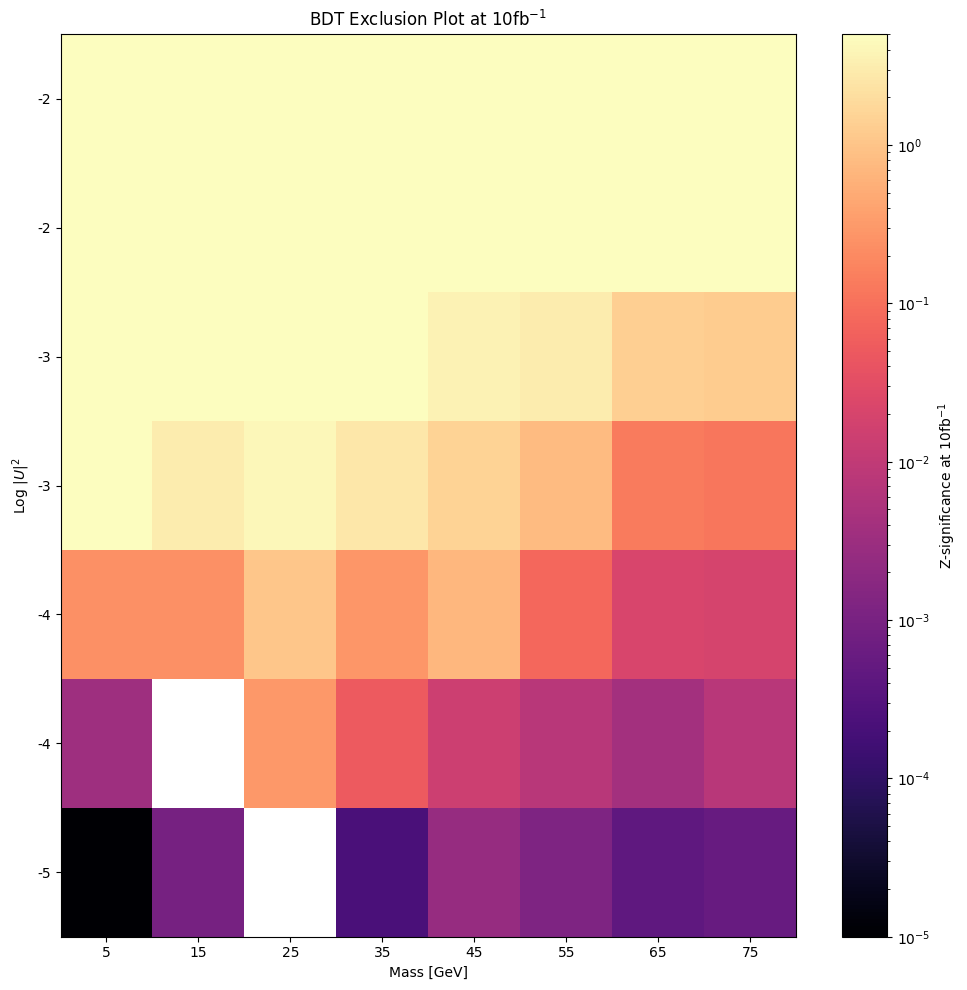

In [47]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
import json

# Load data
with open('test_xgboost_results12_10fb.json', 'r') as file:
    data = json.load(file)

def make_hist_2D():
    data_points = []
    for key, value in data.items():
        parts = key.split('_')
        mass = float(parts[1].replace('GeV', ''))
        angle = -float(parts[2].replace('1e-', '').replace('p', '.'))
        highest_significance = max(value['significance_list'], key=lambda x: x[0])[0]
        data_points.append((mass, angle, highest_significance))

    # Extract separate lists of mass, angle, and significance
    masses = [dp[0] for dp in data_points]
    angles = [dp[1] for dp in data_points]
    significances = [dp[2] for dp in data_points]

    # Define plot
    fig, ax = plt.subplots(figsize=(10, 10))
    # Setup bin edges directly on data points
    mass_edges = np.linspace(min(masses) - 5, max(masses) + 5, len(set(masses)) + 1)
    angle_edges = np.linspace(min(angles) - 0.5, max(angles) + 0.5, len(set(angles)) + 1)
    
    # Plotting the heatmap
    H, xedges, yedges = np.histogram2d(masses, angles, bins=(mass_edges, angle_edges), weights=significances)
    H = np.ma.masked_where(H == 0, H)  # Mask zero values to not log them
    mesh = ax.pcolormesh(xedges, yedges, H.T, cmap='magma', norm=LogNorm(vmin=1e-5, vmax=5))
    plt.colorbar(mesh, ax=ax, label='Z-significance at $10 \mathrm{fb}^{-1}$')

    # Customizations
    ax.set_xticks((mass_edges[:-1] + mass_edges[1:]) / 2)
    ax.set_yticks((angle_edges[:-1] + angle_edges[1:]) / 2)
    ax.set_xticklabels([f'{int(edge)}' for edge in mass_edges[:-1]])
    ax.set_yticklabels([f'{int(edge)}' for edge in angle_edges[:-1]])

    ax.set_xlabel('Mass [GeV]')
    ax.set_ylabel('Log $|U|^2$')
    ax.set_title("BDT Exclusion Plot at $10 \mathrm{fb}^{-1}$")

    fig.tight_layout()
    plt.savefig('exclusion_plot_10fb_run12.pdf')
    plt.show()

make_hist_2D()


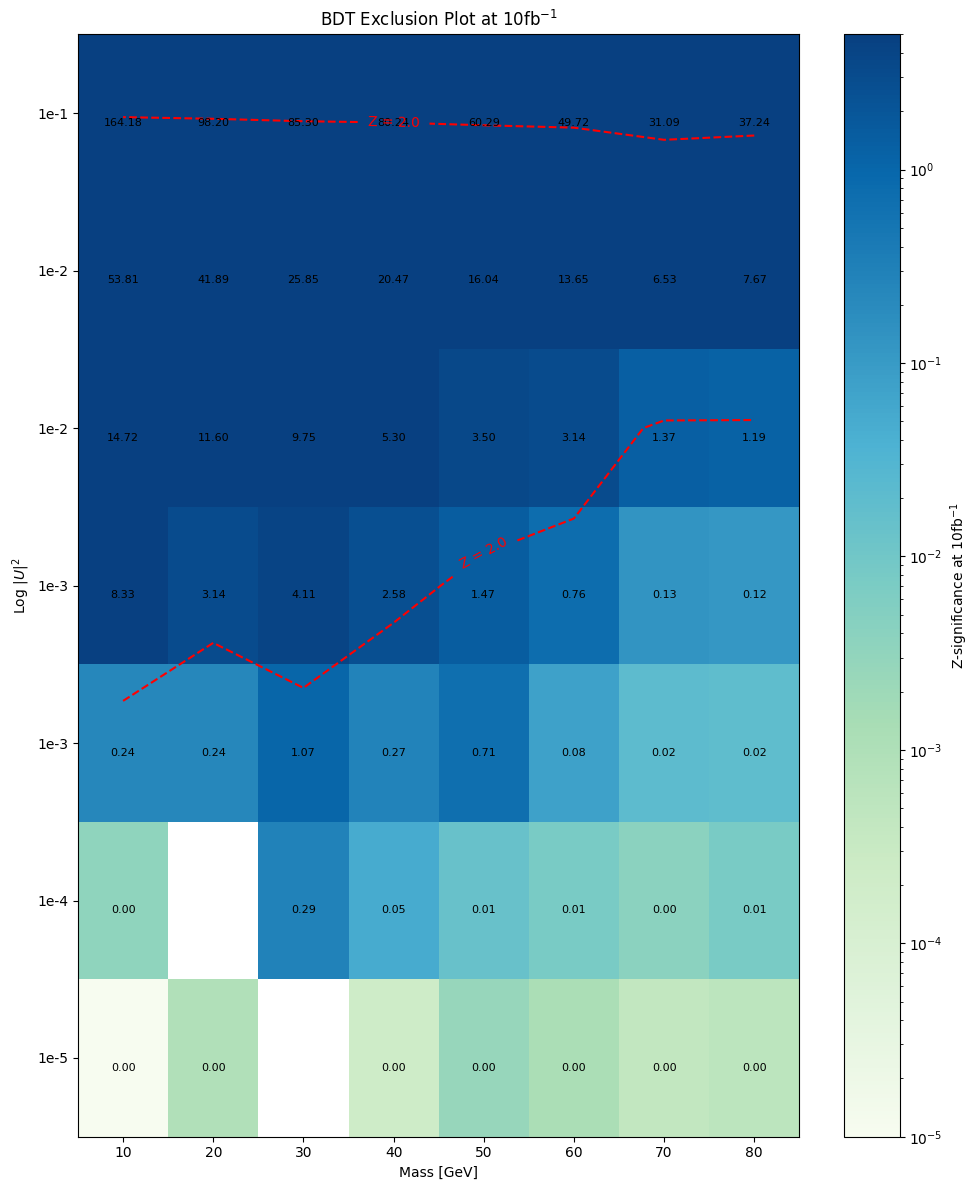

In [70]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
import json
from scipy.interpolate import griddata

# Load data
with open('test_xgboost_results12_10fb.json', 'r') as file:
    data = json.load(file)

def make_hist_2D():
    data_points = []
    for key, value in data.items():
        parts = key.split('_')
        mass = float(parts[1].replace('GeV', ''))
        angle = -float(parts[2].replace('1e-', '').replace('p', '.'))
        highest_significance = max(value['significance_list'], key=lambda x: x[0])[0]
        data_points.append((mass, angle, highest_significance))

    # Extract separate lists of mass, angle, and significance
    masses = [dp[0] for dp in data_points]
    angles = [dp[1] for dp in data_points]
    significances = [dp[2] for dp in data_points]

    # Define plot
    fig, ax = plt.subplots(figsize=(10, 12))
    # Define bin edges centered at mass points 10 to 80 GeV
    mass_edges = np.arange(5, 90, 10)  # from 5 to 85 with step 10
    angle_edges = np.linspace(min(angles) - 0.5, max(angles) + 0.5, len(set(angles)) + 1)

    # Plotting the heatmap
    H, xedges, yedges = np.histogram2d(masses, angles, bins=(mass_edges, angle_edges), weights=significances)
    H = np.ma.masked_where(H == 0, H)  # Mask zero values to not log them
    mesh = ax.pcolormesh(xedges, yedges, H.T, cmap='GnBu', norm=LogNorm(vmin=1e-5, vmax=5))
    plt.colorbar(mesh, ax=ax, label='Z-significance at $10 \mathrm{fb}^{-1}$')

    # Interpolation for contour
    x_center = (xedges[:-1] + xedges[1:]) / 2
    y_center = (yedges[:-1] + yedges[1:]) / 2
    X, Y = np.meshgrid(x_center, y_center)
    Z = griddata((masses, angles), significances, (X, Y), method='cubic', fill_value=0)

    # Adding contour line for Z = 2
    CS = ax.contour(X, Y, Z, levels=[2], colors='red', linestyles='dashed')
    ax.clabel(CS, inline=True, fontsize=10, fmt='Z = %1.1f')

    # Customizations
    ax.set_xticks((mass_edges[:-1] + mass_edges[1:]) / 2)
    ax.set_yticks((angle_edges[:-1] + angle_edges[1:]) / 2)
    ax.set_xticklabels([f'{int(edge)}' for edge in mass_edges[:-1] + 5])  # Adjust labels to be centered
    ax.set_yticklabels([f'1e{int(edge)}' for edge in angle_edges[:-1] + 0.5])

    # Label each cell with its significance value
    for i in range(len(xedges) - 1):
        for j in range(len(yedges) - 1):
            if H[i, j] > 0:
                ax.text(xedges[i] + 5, yedges[j] + 0.25, f'{H[i, j]:.2f}', color='black', ha='center', va='center', fontsize=8)

    ax.set_xlabel('Mass [GeV]')
    ax.set_ylabel('Log $|U|^2$')
    ax.set_title("BDT Exclusion Plot at $10 \mathrm{fb}^{-1}$")

    fig.tight_layout()
    plt.savefig('exclusion_plot_10fb_run12.pdf')
    plt.show()

make_hist_2D()


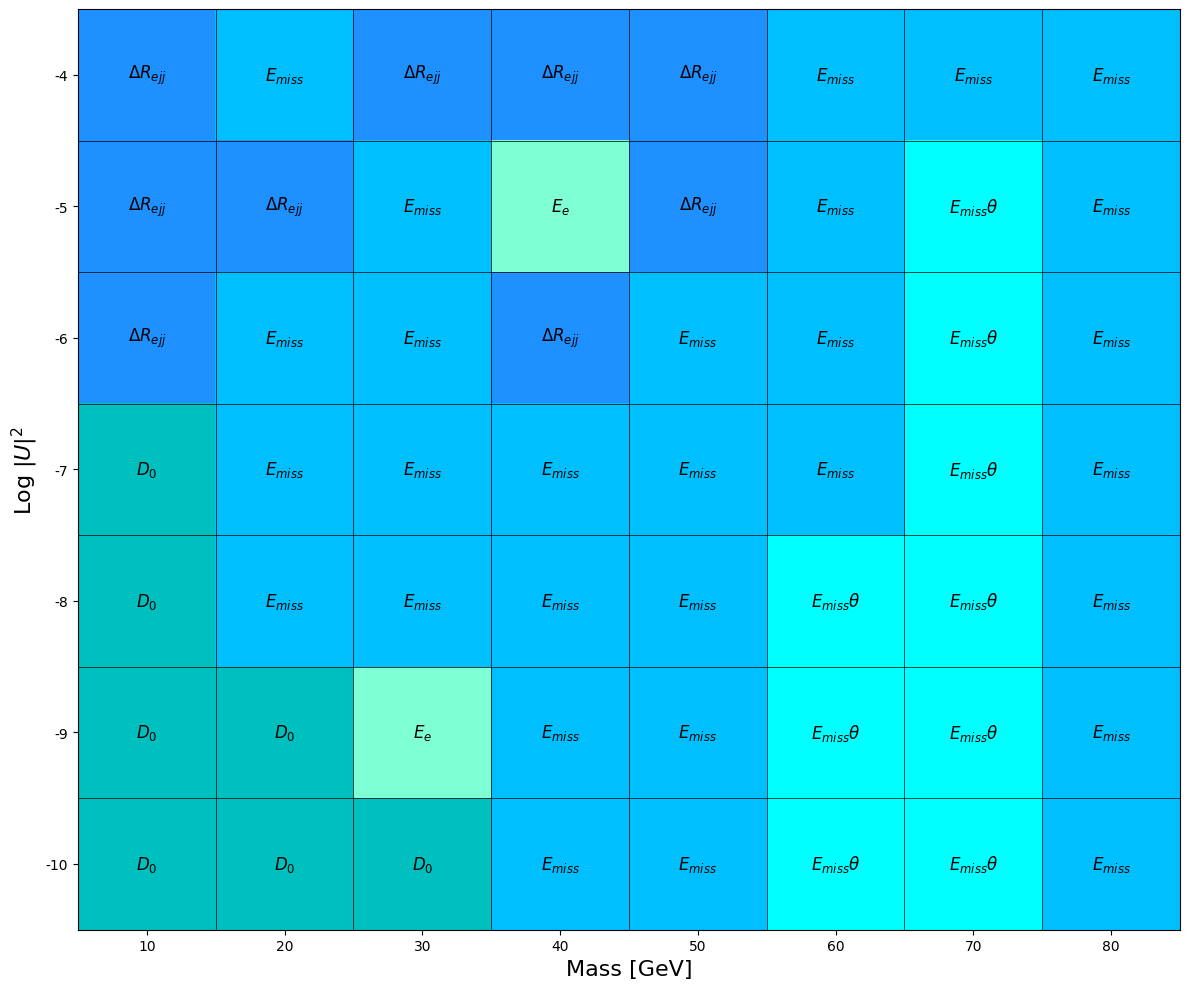

In [134]:
## DNN feature importance

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Define mass points and mixing angles
masses = np.arange(10, 90, 10)  # Mass points from 10 to 80 GeV
mixing_angles = ['-4', '-5', '-6', '-7', '-8', '-9', '-10']  # Mixing angles from 10^-4 to 10^-10

important_features = [
    [r'$\Delta R_{ejj}$', r'$E_{miss}$', r'$\Delta R_{ejj}$', r'$\Delta R_{ejj}$', r'$\Delta R_{ejj}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$'],   
    [r'$\Delta R_{ejj}$', r'$\Delta R_{ejj}$', r'$E_{miss}$', r'$E_{e}$', r'$\Delta R_{ejj}$', r'$E_{miss}$', r'$E_{miss} \theta$', r'$E_{miss}$'],
    [r'$\Delta R_{ejj}$', r'$E_{miss}$', r'$E_{miss}$', r'$\Delta R_{ejj}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss} \theta$', r'$E_{miss}$'],
    [r'$D_{0}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss} \theta$', r'$E_{miss}$'],
    [r'$D_{0}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss} \theta$', r'$E_{miss} \theta$', r'$E_{miss}$'],
    [r'$D_{0}$', r'$D_{0}$', r'$E_{e}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss} \theta$', r'$E_{miss} \theta$', r'$E_{miss}$'],
    [r'$D_{0}$', r'$D_{0}$', r'$D_{0}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss} \theta$', r'$E_{miss} \theta$', r'$E_{miss}$']
]

unique_features = np.unique(important_features)
feature_to_int = {feature: i for i, feature in enumerate(unique_features)}

# Create a numerical grid for imshow
numerical_grid = np.array([[feature_to_int[feature] for feature in row] for row in important_features])

# Define a color map with specific colors
colors = ['c', 'aquamarine', 'cyan', 'deepskyblue', 'dodgerblue']  # Corresponding to the order of unique_features
cmap = mcolors.ListedColormap(colors)
bounds = np.arange(len(colors) + 1) - 0.5
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Create a square heatmap plot
fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(numerical_grid, cmap=cmap, norm=norm, aspect='auto')
# Set ticks and labels
ax.set_xticks(np.arange(len(masses)))
ax.set_yticks(np.arange(len(mixing_angles)))
ax.set_xticklabels([mass for mass in masses])
ax.set_yticklabels([angle for angle in mixing_angles])


# Add gridlines directly related to the tick marks
ax.set_xticks(np.arange(len(masses) + 1) - 0.5, minor=True)
ax.set_yticks(np.arange(len(mixing_angles) + 1) - 0.5, minor=True)
ax.grid(which='minor', color='black', linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", size=0)  # Hide minor tick marks

# Set axis labels with increased font size
ax.set_xlabel('Mass [GeV]', fontsize=16)
ax.set_ylabel(r'Log $|U|^2$', fontsize=16)

for i in range(len(mixing_angles)):
    for j in range(len(masses)):
        ax.text(j, i, important_features[i][j],
                ha="center", va="center", color="black", fontsize=12)  # Increase font size for feature labels


fig.tight_layout()
plt.savefig(f"BDT_features_best.pdf")


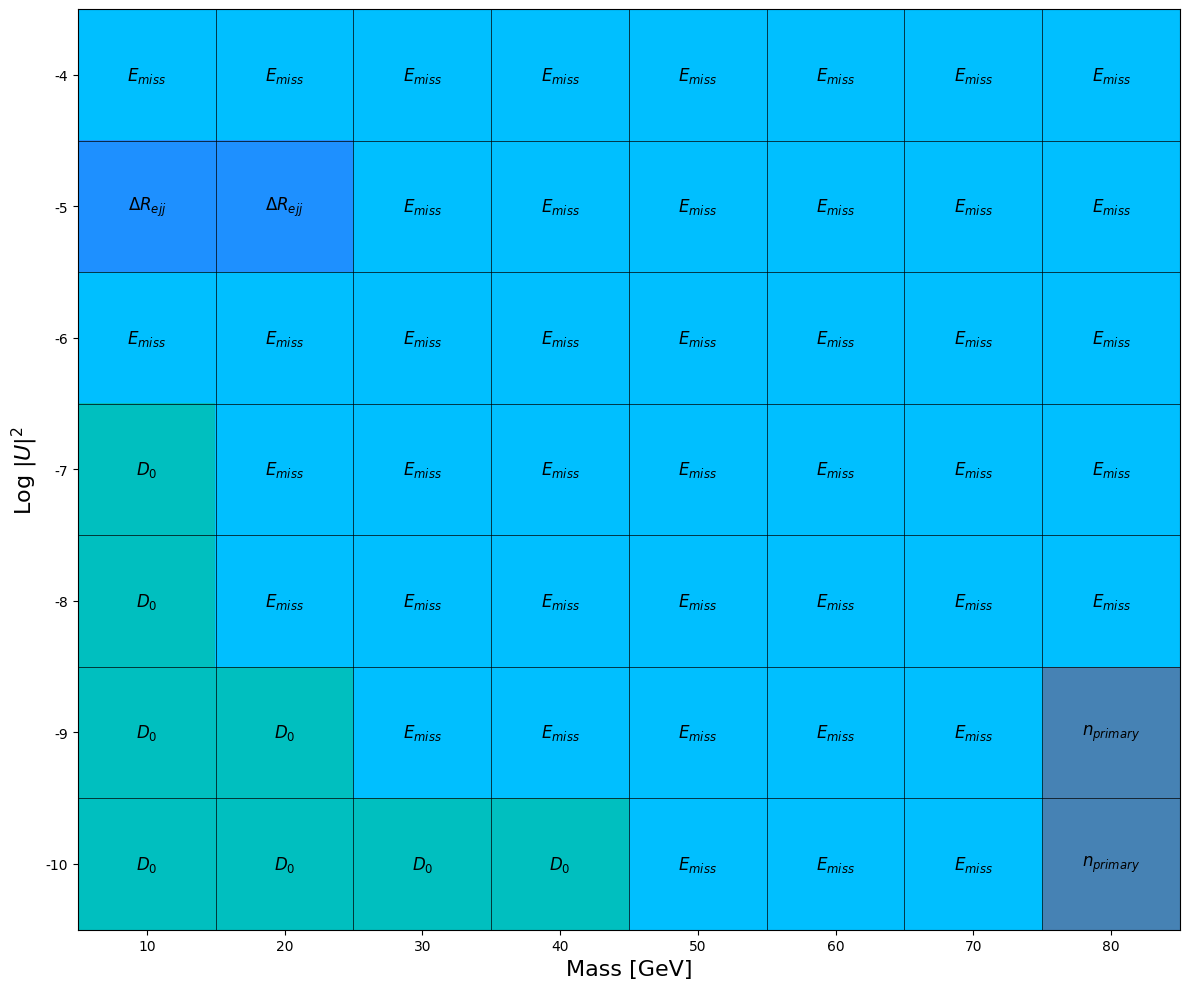

In [147]:
## DNN feature importance

import matplotlib.pyplot as plt
import numpy as np

# Define mass points and mixing angles
masses = np.arange(10, 90, 10)  # Mass points from 10 to 80 GeV
mixing_angles = ['-4', '-5', '-6', '-7', '-8', '-9', '-10']  # Mixing angles from 10^-4 to 10^-10

important_features = [
    [r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$'],   
    [r'$\Delta R_{ejj}$', r'$\Delta R_{ejj}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$'],
    [r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$'],
    [r'$D_{0}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$'],
    [r'$D_{0}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$'],
    [r'$D_{0}$', r'$D_{0}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$n_{primary}$'],
    [r'$D_{0}$', r'$D_{0}$', r'$D_{0}$', r'$D_{0}$', r'$E_{miss}$', r'$E_{miss}$', r'$E_{miss}$', r'$n_{primary}$']
]

unique_features = np.unique(important_features)
feature_to_int = {feature: i for i, feature in enumerate(unique_features)}

# Create a numerical grid for imshow
numerical_grid = np.array([[feature_to_int[feature] for feature in row] for row in important_features])

# Define a color map with specific colors
colors = ['c', 'deepskyblue', 'dodgerblue', 'steelblue'] # Corresponding to the order of unique_features
cmap = mcolors.ListedColormap(colors)
bounds = np.arange(len(colors) + 1) - 0.5
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Create a square heatmap plot
fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(numerical_grid, cmap=cmap, norm=norm, aspect='auto')
# Set ticks and labels
ax.set_xticks(np.arange(len(masses)))
ax.set_yticks(np.arange(len(mixing_angles)))
ax.set_xticklabels([mass for mass in masses])
ax.set_yticklabels([angle for angle in mixing_angles])


# Add gridlines directly related to the tick marks
ax.set_xticks(np.arange(len(masses) + 1) - 0.5, minor=True)
ax.set_yticks(np.arange(len(mixing_angles) + 1) - 0.5, minor=True)
ax.grid(which='minor', color='black', linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", size=0)  # Hide minor tick marks

# Set axis labels with increased font size
ax.set_xlabel('Mass [GeV]', fontsize=16)
ax.set_ylabel(r'Log $|U|^2$', fontsize=16)

for i in range(len(mixing_angles)):
    for j in range(len(masses)):
        ax.text(j, i, important_features[i][j],
                ha="center", va="center", color="black", fontsize=12)  # Increase font size for feature labels


fig.tight_layout()
plt.savefig(f"DNN_features_best.pdf")
